 # Imports

In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

import lightning.pytorch as pl
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.torch.model.tft.module import TemporalFusionTransformerModel
# from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.common import (
    FileDataset, ListDataset, TrainDatasets,
    CategoricalFeatureInfo, BasicFeatureInfo,
)
from gluonts.dataset.loader import TrainDataLoader, InferenceDataLoader
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from datasets import Dataset, Features, Value, Sequence
from omegaconf import OmegaConf


/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import metrics

In [14]:
data_percentages = OmegaConf.load('confs/transfer_learning.yaml')
percentages = data_percentages.percentages

In [3]:
id_sensor = pd.read_csv('/home/seyed/PycharmProjects/step/STEP/datasets/METR-LA/graph_sensor_locations.csv', index_col=0)
adj_path = "/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/METR-LA/adj_METR-LA_nn.json"
rev_map = json.loads(id_sensor["sensor_id"].to_json())
main_map = {str(v):k for k,v in rev_map.items()}
nn_data = None
with open(adj_path, "r") as f:
    nn_data = json.load(f)
q = []
for i in nn_data:
    if i != "26":
        if len(nn_data[i]["1_hop"]["nodes"]) == 1:
            print(i, nn_data[i], rev_map[str(i)])
        q.append(len(nn_data[i]["1_hop"]["nodes"]))
DROP_IND = "26"
DROP_SENSOR = rev_map[DROP_IND]
df = pd.read_hdf("/home/seyed/Downloads/metr-la(1).h5")
df_new = df.copy()
aggregated = []
# ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")
KNN = 3
for column in df_new.columns:
    if column != str(DROP_SENSOR):
        first_nn = nn_data[main_map[column]]["1_hop"]["nodes"]
        cols = [str(rev_map[str(i)]) for i in first_nn[:KNN]]
        aggregated.append(df_new[cols].values.T)
df.drop(columns=[str(DROP_SENSOR)], inplace=True)
df_new.drop(columns=[str(DROP_SENSOR)], inplace=True)
df.index = pd.to_datetime(df.index)
df.index.freq='5min'
history_seq_len = 2016
future_seq_len = 12
len_of_df = len(df)
num_samples = len_of_df - (history_seq_len + future_seq_len) + 1
    # keep same number of validation and test samples with Graph WaveNet (input 12, output 12)
test_num_short = 200
valid_num_short = 200
# train_num_short = num_samples - valid_num_short - test_num_short
train_num_short = 30000
train_data = df[:train_num_short]
feat_time = [ddd[:, :train_num_short] for ddd in aggregated]
test_data = df
feat_time[0].shape
def to_deepar_format(dataframe, time_feature):
    freq = pd.infer_freq(dataframe.index) 
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
                FieldName.FEAT_DYNAMIC_REAL: time_feature[i],
                FieldName.ITEM_ID: i,
                "data_id": i
            } 
            for i, c in enumerate(dataframe.columns)
    ]
    # print(data[0]["feat_dynamic_real"].shape)
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, feat_time)
test_data_lds = to_deepar_format(test_data, aggregated)


In [36]:

# id_sensor = pd.read_csv('/home/seyed/PycharmProjects/step/STEP/datasets/METR-LA/graph_sensor_locations.csv', index_col=0)
# adj_path = "/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/METR-LA/adj_METR-LA_nn.json"
# rev_map = json.loads(id_sensor["sensor_id"].to_json())
# main_map = {str(v):k for k,v in rev_map.items()}
# nn_data = None
# with open(adj_path, "r") as f:
#     nn_data = json.load(f)
# q = []
# for i in nn_data:
#     if i != "26":
#         if len(nn_data[i]["1_hop"]["nodes"]) == 1:
#             print(i, nn_data[i], rev_map[str(i)])
#         q.append(len(nn_data[i]["1_hop"]["nodes"]))
KNN = 3
df_pems4 = np.load("/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/PEMS04/PEMS04.npz")["data"]
df_pems4_new = pd.DataFrame(df_pems4[:,:,0])


def dataset_factory(df_pems4_new, windows: List[tuple[int, ...]]=None):
    aggregated_04 = []
    import datetime
    from sklearn.neighbors import NearestNeighbors
    neigh = NearestNeighbors(n_neighbors=KNN)
    neigh.fit(df_pems4_new.T.values)
    k_nn = neigh.kneighbors_graph().toarray()
    for column in df_pems4_new.columns:
        first_nn = [c for c, val in enumerate(k_nn[column]) if val == 1]
        aggregated_04.append(df_pems4_new[first_nn].values.T)
    train_num_short = int(df_pems4_new.shape[0]* 0.7)
    train_data_04 = df_pems4_new[:train_num_short]
    feat_time_04 = [ddd[:, :train_num_short] for ddd in aggregated_04]
    feat_time_04[0].shape
    def to_deepar_format(dataframe, time_feature, index=None):
        freq = "5min"
        start_index = datetime.datetime(2018, 1, 1, 0, 0)
        if windows:
            data = [{
                        FieldName.START:  start_index if (index is None and windows is None) else start_index + datetime.timedelta(minutes=index * 5) if windows is None else start_data,
                        FieldName.TARGET:  dataframe[c].values,
                        FieldName.FEAT_DYNAMIC_REAL: time_feature[i],
                        FieldName.ITEM_ID: i,
                        "data_id": i
                    } 
                    for i, c in enumerate(dataframe.columns) for start_data, _ in windows]
        else:
            data = [{
                        FieldName.START:  start_index if (index is None and windows is None) else start_index + datetime.timedelta(minutes=index * 5),
                        FieldName.TARGET:  dataframe[c].values,
                        FieldName.FEAT_DYNAMIC_REAL: time_feature[i],
                        FieldName.ITEM_ID: i,
                        "data_id": i
                    } 
                    for i, c in enumerate(dataframe.columns)]
        return ListDataset(data, freq=freq)
    train_data_lds_04 = to_deepar_format(train_data_04, feat_time_04)
    test_data_lds_04 = to_deepar_format(df_pems4_new, aggregated_04)

    return train_data_lds_04, test_data_lds_04

In [25]:
df_pems4_new.set_index(pd.date_range(start="2018-01-01", periods=df_pems4_new.shape[0], freq="5min"), inplace=True)

In [34]:
import datetime


def df_sampler(input_df):
    current_percent = percentages[0]
    possible_indices = list(range(0, len(df_pems4_new)- round(16992 * (current_percent/100))))
    sampled_indices = np.random.choice(possible_indices, current_percent, replace=False)
    context_window = 192
    start_offset = datetime.datetime(2018, 1, 1, 0, 0)
    dates = [(start_offset + datetime.timedelta(minutes=int(i) * 5), 0) for i in sampled_indices]
    df_merged = pd.concat([input_df.iloc[index: index + context_window + 1] for index in sampled_indices])
    return df_merged, dates
sampled_df, dates = df_sampler(df_pems4_new)

In [37]:
train_data_lds_04, test_data_lds_04 = dataset_factory(sampled_df, windows=dates)

In [5]:
def to_deepar_format_all(dataframe, time_feature, d2, t2):
    freq = pd.infer_freq(dataframe.index) 
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
                FieldName.FEAT_DYNAMIC_REAL: time_feature[i],
                FieldName.ITEM_ID: i,
                "data_id": i
            } 
            for i, c in enumerate(dataframe.columns)]
    data2 = [{
                FieldName.START:  datetime.datetime(2018, 1, 1, 0, 0),
                FieldName.TARGET:  d2[c].values,
                FieldName.FEAT_DYNAMIC_REAL: t2[i],
                FieldName.ITEM_ID: i,
                "data_id": i
            } 
            for i, c in enumerate(d2.columns)]
    data.extend(data2)
    # print(data[0]["feat_dynamic_real"].shape)
    return ListDataset(data, freq=freq)
train_data_all_lds = to_deepar_format_all(train_data, feat_time, train_data_04, feat_time_04)
test_data_all_lds = to_deepar_format_all(test_data, aggregated, test_data_04, aggregated_04)


In [6]:
train_data_metrla = to_deepar_format(train_data, feat_time)
test_data_lds_metrla = to_deepar_format(test_data, aggregated)


In [42]:
from gluonts.dataset.common import MetaData
meta_data = MetaData(freq="5T", prediction_length=future_seq_len)
# dataset_metr_la = TrainDatasets(train=train_data_metrla, test=test_data_lds_metrla, metadata=meta_data)
# dataset_04 = TrainDatasets(train=train_data_lds_04, test=test_data_lds_04, metadata=meta_data)
meta_data


MetaData(freq='5T', target=None, feat_static_cat=[], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=12)

In [43]:
dataset_04_list = TrainDatasets(train=train_data_lds_04, test=test_data_lds_04, metadata=meta_data)
# train_data_lds_04
# test_data_lds_04


In [44]:
dataset_metr_la = TrainDatasets(train=train_data_metrla, test=test_data_lds_metrla, metadata=meta_data)


NameError: name 'train_data_metrla' is not defined

In [11]:
multi_variate_train_dataset = dataset_04_list.train

In [12]:
from functools import lru_cache


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [13]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = len(dataset_04_list.train)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=1, # number of rolling test windows
)


In [14]:

multi_variate_train_dataset = train_grouper(dataset_04_list.train)

In [15]:
multi_variate_test_dataset = test_grouper(dataset_04_list.test)

In [16]:
multi_variate_test_dataset[0]["target"].shape

(307, 16992)

In [17]:
prediction_length=12

In [19]:
##################
# Instance Splitter

class InstanceSplitter(FlatMapTransformation):

    @validated()
    def __init__(
        self,
        target_field: str,
        is_pad_field: str,
        start_field: str,
        forecast_start_field: str,
        instance_sampler: InstanceSampler,
        past_length: int,
        future_length: int,
        lead_time: int = 0,
        output_NTC: bool = True,
        time_series_fields: List[str] = [],
        dummy_value: float = 0.0,
    ) -> None:
        super().__init__()

        assert future_length > 0, "The value of `future_length` should be > 0"

        self.instance_sampler = instance_sampler
        self.past_length = past_length
        self.future_length = future_length
        self.lead_time = lead_time
        self.output_NTC = output_NTC
        self.ts_fields = time_series_fields
        self.target_field = target_field
        self.is_pad_field = is_pad_field
        self.start_field = start_field
        self.forecast_start_field = forecast_start_field
        self.dummy_value = dummy_value

    def _past(self, col_name):
        return f"past_{col_name}"

    def _future(self, col_name):
        return f"future_{col_name}"

    def flatmap_transform(
        self, data: DataEntry, is_train: bool
    ) -> Iterator[DataEntry]:
        future_length = self.future_length
        lt = self.lead_time
        slice_cols = self.ts_fields + [self.target_field]
        target = data[self.target_field]
        if self.instance_sampler.__class__.__name__ == "ValidSplitSampler":
            sampled_indices = self.instance_sampler(target, offset=-100)
            print(sampled_indices)
        else:
            sampled_indices = self.instance_sampler(target)

        for i in sampled_indices:
            pad_length = max(self.past_length - i, 0)
            d = data.copy()
            for ts_field in slice_cols:
                if i > self.past_length:
                    # truncate to past_length
                    past_piece = d[ts_field][..., i - self.past_length : i]
                elif i < self.past_length:
                    pad_block = (
                        np.ones(
                            d[ts_field].shape[:-1] + (pad_length,),
                            dtype=d[ts_field].dtype,
                        )
                        * self.dummy_value
                    )
                    past_piece = np.concatenate(
                        [pad_block, d[ts_field][..., :i]], axis=-1
                    )
                else:
                    past_piece = d[ts_field][..., :i]
                d[self._past(ts_field)] = past_piece
                d[self._future(ts_field)] = d[ts_field][
                    ..., i + lt : i + lt + future_length
                ]
                del d[ts_field]
            pad_indicator = np.zeros(self.past_length, dtype=target.dtype)
            if pad_length > 0:
                pad_indicator[:pad_length] = 1

            if self.output_NTC:
                for ts_field in slice_cols:
                    d[self._past(ts_field)] = d[
                        self._past(ts_field)
                    ].transpose()
                    d[self._future(ts_field)] = d[
                        self._future(ts_field)
                    ].transpose()

            d[self._past(self.is_pad_field)] = pad_indicator
            d[self.forecast_start_field] = d[self.start_field] + i + lt
            yield d

In [21]:
from gluonts.time_feature import get_lags_for_frequency
freq = "5min"
lags_sequence = get_lags_for_frequency(freq)

from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

model = InformerForPrediction(config)
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    ExpectedNumInstanceSampler,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

from gluonts.core.component import validated, tensor_to_numpy
from gluonts.dataset.common import DataEntry
from gluonts.exceptions import assert_data_error
from gluonts.transform import SimpleTransformation
from typing import Iterator, Type

class AsNumpyArray(SimpleTransformation):
    """
    Converts the value of a field into a numpy array.

    Parameters
    ----------
    expected_ndim
        Expected number of dimensions. Throws an exception if the number of
        dimensions does not match.
    dtype
        numpy dtype to use.
    """

    @validated()
    def __init__(
        self, field: str, expected_ndim: int, dtype: Type = np.float32
    ) -> None:
        self.field = field
        self.expected_ndim = expected_ndim
        self.dtype = dtype

    def transform(self, data: DataEntry) -> DataEntry:
        value = np.asarray(data[self.field], dtype=self.dtype)
        if value.shape[0] == 1 or value.shape[-1] == 1:
            value = value.ravel()
        assert_data_error(
            value.ndim == self.expected_ndim,
            'Input for field "{self.field}" does not have the required'
            "dimension (field: {self.field}, ndim observed: {value.ndim}, "
            "expected ndim: {self.expected_ndim})",
            value=value,
            self=self,
        )
        data[self.field] = value
        return data

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

from gluonts.transform.sampler import InstanceSampler
from typing import Optional, Type
from gluonts.transform._base import FlatMapTransformation





class ValidSplitSampler(InstanceSampler):
    """
    Sampler used for prediction.

    Always selects the last time point for splitting i.e. the forecast point
    for the time series.
    """

    allow_empty_interval: bool = False

    def __call__(self, ts: np.ndarray, offset=None) -> np.ndarray:
        a, b = self._get_bounds(ts)
        assert self.allow_empty_interval or a <= b
        if offset is None:
            return np.array(list(range(a, b+1))) if a <= b else np.array([], dtype=int)
        else:
            return np.array(list(range(b+offset, b+1))) if a <= b else np.array([], dtype=int)


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())


outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())

from accelerate import Accelerator
from torch.optim import AdamW

epochs = 30
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

[<function minute_of_hour at 0x77718eb018a0>, <function hour_of_day at 0x77718eb019e0>, <function day_of_week at 0x77718eb01b20>, <function day_of_month at 0x77718eb01c60>, <function day_of_year at 0x77718eb01da0>]
past_time_features torch.Size([256, 192, 6]) torch.FloatTensor
past_values torch.Size([256, 192, 307]) torch.FloatTensor
past_observed_mask torch.Size([256, 192, 307]) torch.FloatTensor
future_time_features torch.Size([256, 12, 6]) torch.FloatTensor
future_values torch.Size([256, 12, 307]) torch.FloatTensor
future_observed_mask torch.Size([256, 12, 307]) torch.FloatTensor
Loss: 2033.5118408203125
2053.847412109375
1635.806640625
1573.9456787109375
1519.7994384765625
1514.1517333984375
1488.7601318359375
1494.5252685546875
1498.3511962890625
1480.9605712890625
1491.3599853515625
1461.7603759765625
1475.09765625
1433.0394287109375
1451.984375
1443.8369140625
1455.1392822265625
1465.6334228515625
1443.7080078125
1469.875
1465.2183837890625
1414.2218017578125
1439.68408203125
14

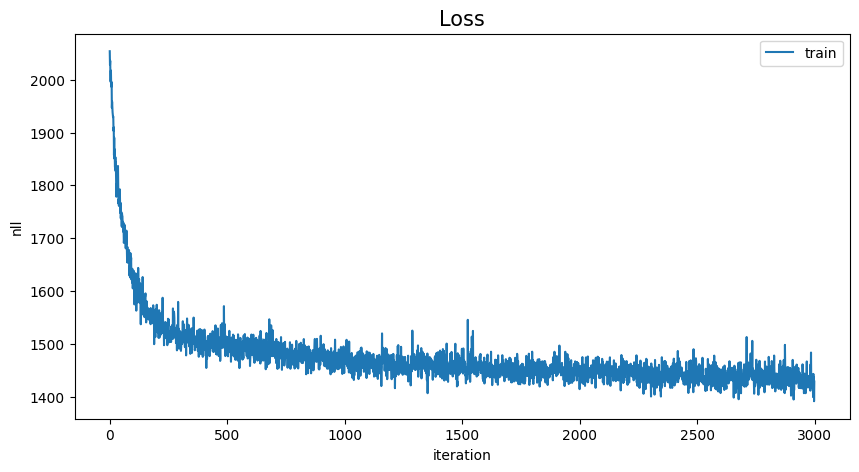

In [22]:
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

In [23]:
test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)


In [25]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)
print(forecasts.shape)

[16880 16881 16882 16883 16884 16885 16886 16887 16888 16889 16890 16891
 16892 16893 16894 16895 16896 16897 16898 16899 16900 16901 16902 16903
 16904 16905 16906 16907 16908 16909 16910 16911 16912 16913 16914 16915
 16916 16917 16918 16919 16920 16921 16922 16923 16924 16925 16926 16927
 16928 16929 16930 16931 16932 16933 16934 16935 16936 16937 16938 16939
 16940 16941 16942 16943 16944 16945 16946 16947 16948 16949 16950 16951
 16952 16953 16954 16955 16956 16957 16958 16959 16960 16961 16962 16963
 16964 16965 16966 16967 16968 16969 16970 16971 16972 16973 16974 16975
 16976 16977 16978 16979 16980]
(101, 100, 12, 307)


In [35]:
import metrics

START_INDEX = 16880
forecast_median = np.median(forecasts, 1)

mae_metrics = []
rmse_metrics = []
mape_metrics = []
for jjj, forecast_index in enumerate(range(START_INDEX, START_INDEX+101)):
    mae_metrics_inner = []
    rmse_metrics_inner = []
    mape_metrics_inner = []
    for item_id, ts in enumerate(dataset_04_list.test):
        # print(ts.keys())
        ground_truth = ts["target"][forecast_index:forecast_index+prediction_length]
        # print(ground_truth.shape, forecast_median[item_id].shape)
        rmse = metrics.rmse(forecast_median[jjj,:,item_id],ground_truth)
        mae = metrics.mae(forecast_median[jjj,:,item_id],ground_truth)
        mape = metrics.mape(forecast_median[jjj,:,item_id],ground_truth)
        mae_metrics_inner.append(mae)
        rmse_metrics_inner.append(rmse)
        mape_metrics_inner.append(mape)
    mae_metrics.append(np.mean(mae_metrics_inner))
    rmse_metrics.append(np.mean(rmse_metrics_inner))
    mape_metrics.append(np.mean(mape_metrics_inner))

In [36]:
print(f"MAE: {np.mean(mae_metrics)}")

MAE: 50.701454162597656


In [37]:
print(f"MAPE: {np.mean(mape_metrics)}")

MAPE: 0.224550262093544


In [38]:
print(f"RMSE: {np.mean(rmse_metrics)}")

RMSE: 55.66080856323242


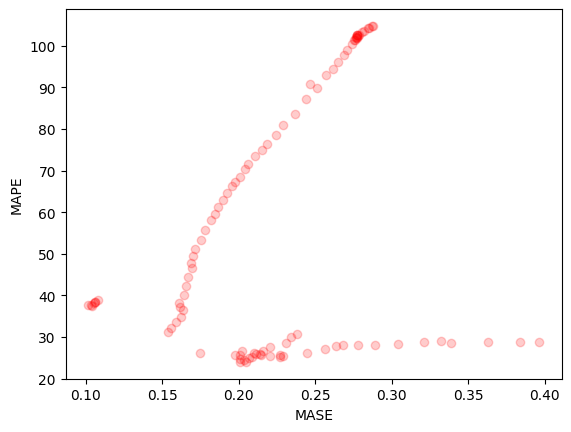

In [39]:
plt.scatter(mape_metrics, rmse_metrics, alpha=0.2, c="r")
plt.xlabel("MASE")
plt.ylabel("MAPE")
plt.show()

In [ ]:
############################################################################################################

In [10]:
forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())



In [11]:
import os

file_path = "./checkpoints/lag-llama.ckpt"
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")



File exists


In [12]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.empty_cache()



 # A3, A4 Experiments

In [13]:
# A3 exprient

from lag_llama.gluon.estimator import LagLlamaEstimator

ckpt = torch.load("/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_134/checkpoints/epoch=99-step=100000.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
# input_size = estimator_args["input_size"]
input_size = estimator_args["input_size"]
estimator = LagLlamaEstimator(
    ckpt_path=None,
    prediction_length=12,
    context_length=48,
    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    num_batches_per_epoch=100,
    trainer_kwargs = {"max_epochs": 50,}
)




In [14]:
# A4 exprient
predictor = estimator.train(dataset_04_list.train, use_lora=False, ckpt_path="/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_225/checkpoints/epoch=49-step=15000.ckpt")

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_225/checkpoints/epoch=49-step=15000.ckpt
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: The dirpath has cha

/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_225/checkpoints/epoch=49-step=15000.ckpt


In [15]:
estimator.ckpt_path = "/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_225/checkpoints/epoch=49-step=15000.ckpt"

In [16]:
# A4 exprient
from gluonts.evaluation import Evaluator

num_rmse = []
num_mape = []
num_mae = []

test_loader = estimator.create_test_dataloader(module=estimator.create_lightning_module(use_lora=False),freq="5T", data=dataset_04_list.test, batch_size=8)

#     forecast_it, ts_it = mak

In [17]:
forecasts_ = []
for batch in test_loader:
    forecasts_.append(estimator.create_lightning_module(use_lora=False)(past_target=batch["past_target"].to(predictor.device), past_observed_values=batch["past_observed_values"].to(predictor.device), past_time_feat=batch["past_time_feat"].to(predictor.device), future_time_feat=batch["future_time_feat"].to(predictor.device)))

In [24]:
len(forecasts_)
forecast_np = [tensor.detach().cpu().numpy() for tensor in forecasts_]

In [32]:
batch

{'past_target': tensor([[64., 65., 74.,  ..., 85., 69., 80.],
         [48., 43., 50.,  ..., 58., 52., 78.],
         [51., 35., 47.,  ..., 57., 43., 40.]]),
 'past_observed_values': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 'future_target': tensor([], size=(3, 0)),
 'future_observed_values': tensor([], size=(3, 0)),
 'past_time_feat': tensor([[[ 0.3475,  0.2391,  0.5000, -0.0667, -0.4644],
          [ 0.4322,  0.2391,  0.5000, -0.0667, -0.4644],
          [-0.5000,  0.2826,  0.5000, -0.0667, -0.4644],
          ...,
          [ 0.0932,  0.1957,  0.0000,  0.0667, -0.4534],
          [ 0.1780,  0.1957,  0.0000,  0.0667, -0.4534],
          [ 0.2627,  0.1957,  0.0000,  0.0667, -0.4534]],
 
         [[ 0.3475,  0.2391,  0.5000, -0.0667, -0.4644],
          [ 0.4322,  0.2391,  0.5000, -0.0667, -0.4644],
          [-0.5000,  0.2826,  0.5000, -0.0667, -0.4644],
          ...,
          [ 0.0932,  0.1957,  0.00

In [26]:
del forecasts_

In [27]:
forecasts = np.vstack(forecast_np)

In [28]:
forecasts.shape

(307, 100, 12)

In [33]:
# make_evaluation_predictions(
#         dataset=sampled_dataset.test,  # test dataset
#         predictor=predictor,  # predictor
#         num_samples=100,  # number of sample paths we want for evaluation
#         )
#     evaluator = Evaluator(
#         custom_eval_fn={
#             "mae_sota": [metrics.mae, "mean", "median"],
#             "mape_sota": [metrics.mape, "mean", "median"],
#             "rmse_sota": [metrics.rmse, "mean", "median"]
#         }
#     )
#     agg_m, item_m = evaluator(
#         ts_iterator=ts_it,
#         fcst_iterator=forecast_it,
#         num_series=len(sampled_dataset.test),
#     )
#     num_rmse.append(agg_m["rmse_sota"])
#     num_mape.append(agg_m["mape_sota"])
#     num_mae.append(agg_m["mae_sota"])

#     if iii % 10 == 9:
#         print(num_rmse, num_mape, num_mae)
#         break


(5098,)

In [20]:
dataset_04.train

[{'start': Period('2018-01-01 00:00', '5T'),
  'target': array([62., 61., 71., ..., 66., 77., 74.], dtype=float32),
  'feat_dynamic_real': array([[ 47.,  36.,  53., ...,  89.,  77.,  56.],
         [ 85.,  70.,  82., ..., 112.,  98.,  81.],
         [ 76.,  62.,  77., ...,  90.,  93.,  86.]], dtype=float32),
  'item_id': 0,
  'data_id': 0},
 {'start': Period('2018-01-01 00:00', '5T'),
  'target': array([56., 40., 28., ..., 76., 73., 71.], dtype=float32),
  'feat_dynamic_real': array([[60., 67., 71., ..., 72., 64., 70.],
         [29., 30., 30., ..., 33., 41., 49.],
         [62., 59., 59., ..., 64., 67., 60.]], dtype=float32),
  'item_id': 1,
  'data_id': 1},
 {'start': Period('2018-01-01 00:00', '5T'),
  'target': array([90., 94., 79., ..., 77., 96., 64.], dtype=float32),
  'feat_dynamic_real': array([[50., 36., 52., ..., 65., 61., 54.],
         [39., 31., 45., ..., 37., 44., 43.],
         [48., 34., 46., ..., 43., 41., 28.]], dtype=float32),
  'item_id': 2,
  'data_id': 2},
 {'star